In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.compose import ColumnTransformer,make_column_selector

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel

from sklearn import svm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler,FunctionTransformer,OneHotEncoder,OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import TransformedTargetRegressor


from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression,Ridge

from sklearn.decomposition import PCA

In [2]:
train_data_original = pd.read_csv('Housing_dataset_train.csv',index_col="ID")
# train_data_original = pd.read_csv('cleaned3.csv',index_col="ID")
test_data = pd.read_csv('Housing_dataset_test.csv',index_col="ID")

In [3]:
train_data = train_data_original.copy()

train_data.reset_index(inplace=True,drop=True)

test_data.reset_index(inplace=True)
test_ids = test_data['ID']
test_data.drop("ID",inplace=True,axis=1)

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   loc            12187 non-null  object 
 1   title          12278 non-null  object 
 2   bedroom        12201 non-null  float64
 3   bathroom       12195 non-null  float64
 4   parking_space  12189 non-null  float64
 5   price          14000 non-null  float64
dtypes: float64(4), object(2)
memory usage: 656.4+ KB


## Cleaning

In [5]:
non_null = train_data.dropna()


In [6]:
# train_data.dropna(inplace=True)

In [7]:
train_data.drop(train_data[train_data['loc'].isna()].index,axis=0,inplace=True)
train_data.drop(train_data[train_data['title'].isna()].index,axis=0,inplace=True)
train_data.drop(train_data[train_data['bedroom'].isna()].index,axis=0,inplace=True)
train_data.drop(train_data[train_data['bathroom'].isna()].index,axis=0,inplace=True)

# all_numeric_and_loc_nulls =   train_data[train_data['title'].isna() & train_data['bedroom'].isna() & train_data['bathroom'].isna() & train_data['parking_space'].isna()].index
# train_data.drop(all_numeric_and_loc_nulls,inplace=True)

# all_numeric_nulls =   train_data[train_data['bedroom'].isna() & train_data['bathroom'].isna() & train_data['parking_space'].isna()].index
# train_data.drop(all_numeric_nulls,inplace=True)
# bed_and_bath_nulls  =  train_data[train_data['bedroom'].isna() & train_data['bathroom'].isna() ].index
# train_data.drop(bed_and_bath_nulls,inplace=True)



In [8]:
# train_data = train_data[train_data.price < 10_000_000]

In [9]:
# train_data['price_log'] = np.log1p(train_data.price)
# train_data.drop('price',axis=1,inplace=True)

In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7248 entries, 0 to 13997
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   loc            7248 non-null   object 
 1   title          7248 non-null   object 
 2   bedroom        7248 non-null   float64
 3   bathroom       7248 non-null   float64
 4   parking_space  5689 non-null   float64
 5   price          7248 non-null   float64
dtypes: float64(4), object(2)
memory usage: 396.4+ KB


In [11]:

# train_data['mode_title'] = train_data.groupby(['loc'])['title'].transform(lambda x:x.mode()[0])
# train_data.loc[train_data['title'].isna(),'title'] = train_data.loc[train_data['title'].isna(),'mode_title']

# test_data['median_bedroom'] = test_data.groupby(['title','loc'])['bedroom'].transform('median').round()

In [12]:
# train_data.drop(train_data[train_data.duplicated()].index,axis=0,inplace=True)

In [13]:
# fill missing values
train_data['median_bedroom'] = train_data.groupby(['title','loc'])['bedroom'].transform('median').round()
train_data['median_bathroom'] = train_data.groupby(['title','loc'])['bathroom'].transform('median').round()
train_data['median_parking_space'] = train_data.groupby(['title','loc'])['parking_space'].transform('median').round()

train_data.loc[train_data['bedroom'].isna(),'bedroom'] = train_data.loc[train_data['bedroom'].isna(),'median_bedroom']
train_data.loc[train_data['bathroom'].isna(),'bathroom'] = train_data.loc[train_data['bathroom'].isna(),'median_bathroom']
train_data.loc[train_data['parking_space'].isna(),'parking_space'] = train_data.loc[train_data['parking_space'].isna(),'median_parking_space']


In [14]:
train_data.drop(['median_parking_space','median_bathroom','median_bedroom'],axis=1,inplace=True)

In [15]:
# drop all duplicates
train_data.drop(train_data[train_data.duplicated()].index,axis=0,inplace=True)

In [16]:
# train_data['class'] = pd.cut(train_data.price,bins=4,labels=[0,1,2,3]).astype('int')

In [17]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   loc            6000 non-null   object
 1   title          6000 non-null   object
 2   bedroom        6000 non-null   int64 
 3   bathroom       6000 non-null   int64 
 4   parking_space  6000 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 234.5+ KB


In [18]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7179 entries, 0 to 13997
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   loc            7179 non-null   object 
 1   title          7179 non-null   object 
 2   bedroom        7179 non-null   float64
 3   bathroom       7179 non-null   float64
 4   parking_space  7179 non-null   float64
 5   price          7179 non-null   float64
dtypes: float64(4), object(2)
memory usage: 392.6+ KB


In [19]:
# train_data.drop(train_data[train_data.duplicated()].index,axis=0,inplace=True)


# train_data.bedroom.fillna(train_data.bedroom.mean(),axis=0,inplace=True)
# train_data.bathroom.fillna(train_data.bathroom.mean(),axis=0,inplace=True)
# train_data.parking_space.fillna(train_data.parking_space.mean(),axis=0,inplace=True)

In [20]:
def clean_abnormal_bathroom(df):
    # abnormal_bathrooms = df[df.bathroom > df.bedroom]   
    # bedroom = abnormal_bathrooms['bedroom']
    # bathroom = abnormal_bathrooms['bathroom']
    # index = abnormal_bathrooms.index
    # df.loc[index,'bedroom'] = df['bathroom']
    # df.loc[index,'bathroom'] = df['bedroom']
    abnormal_bathrooms = df[df.bedroom < df.bathroom].index
    # df.loc[abnormal_bathrooms,'bathroom'] = df.loc[abnormal_bathrooms,'bedroom'] 
    df.loc[abnormal_bathrooms,'bathroom'] = df.loc[abnormal_bathrooms,'bedroom'] -1
    df.bathroom.replace(0,1,inplace=True)


In [21]:
clean_abnormal_bathroom(train_data)
clean_abnormal_bathroom(test_data)

In [22]:
train_data[train_data.bathroom > train_data.bedroom] 

,loc,title,bedroom,bathroom,parking_space,price


In [23]:
# train_data.drop('parking_space',axis=1,inplace=True)
# test_data.drop('parking_space',axis=1,inplace=True)

In [24]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7179 entries, 0 to 13997
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   loc            7179 non-null   object 
 1   title          7179 non-null   object 
 2   bedroom        7179 non-null   float64
 3   bathroom       7179 non-null   float64
 4   parking_space  7179 non-null   float64
 5   price          7179 non-null   float64
dtypes: float64(4), object(2)
memory usage: 650.6+ KB


In [25]:
train_data.describe()

,bedroom,bathroom,parking_space,price
count,7179.000000,7179.000000,7179.000000,7.179000e+03
mean,4.271068,2.346148,3.125505,2.127662e+06
std,2.426131,1.644957,1.471751,1.059969e+06
min,1.000000,1.000000,1.000000,4.319673e+05
25%,2.000000,1.000000,2.000000,1.394770e+06
50%,4.000000,2.000000,3.000000,1.885259e+06
75%,6.000000,3.000000,4.000000,2.574962e+06
max,9.000000,7.000000,6.000000,1.540273e+07


In [26]:
test_data.describe()

,bedroom,bathroom,parking_space
count,6000.000000,6000.000000,6000.000000
mean,4.329833,2.367167,3.132333
std,2.454733,1.673267,1.604551
min,1.000000,1.000000,1.000000
25%,2.000000,1.000000,2.000000
50%,4.000000,2.000000,3.000000
75%,6.000000,3.000000,4.000000
max,9.000000,7.000000,6.000000


In [27]:
non_null.describe()

,bedroom,bathroom,parking_space,price
count,5689.000000,5689.000000,5689.000000,5.689000e+03
mean,4.280014,3.143962,3.151520,2.136072e+06
std,2.427679,2.039221,1.615207,1.057453e+06
min,1.000000,1.000000,1.000000,4.319673e+05
25%,2.000000,1.000000,2.000000,1.398221e+06
50%,4.000000,2.000000,3.000000,1.895944e+06
75%,6.000000,5.000000,4.000000,2.577278e+06
max,9.000000,7.000000,6.000000,1.344942e+07


In [28]:
train_data

,loc,title,bedroom,bathroom,parking_space,price
0,Katsina,Semi-detached duplex,2.0,2.0,1.0,1149999.565
3,Anambra,Detached duplex,5.0,2.0,4.0,2410306.756
7,Katsina,Penthouse,3.0,3.0,5.0,2043107.592
10,Ogun,Bungalow,1.0,1.0,6.0,1330213.036
11,Bayelsa,Apartment,3.0,2.0,2.0,1891772.069
...,...,...,...,...,...,...
13989,Kebbi,Terrace duplex,4.0,3.0,2.0,1581061.171
13990,Kebbi,Penthouse,8.0,7.0,3.0,3086400.032
13992,Ogun,Cottage,1.0,1.0,2.0,1508351.845
13994,Taraba,Detached duplex,8.0,1.0,6.0,2837199.086


## EDA

<AxesSubplot:>

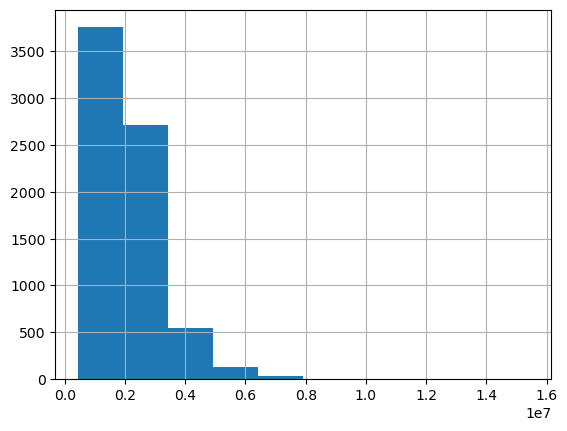

In [29]:
train_data['price'].hist()

In [30]:
# sns.scatterplot(x=train_data['bedroom'], y= train_data['price'],hue=train_data['class'])

In [31]:
# sns.scatterplot(x=train_data['bedroom'], y= train_data['price'],hue=train_data['class'])

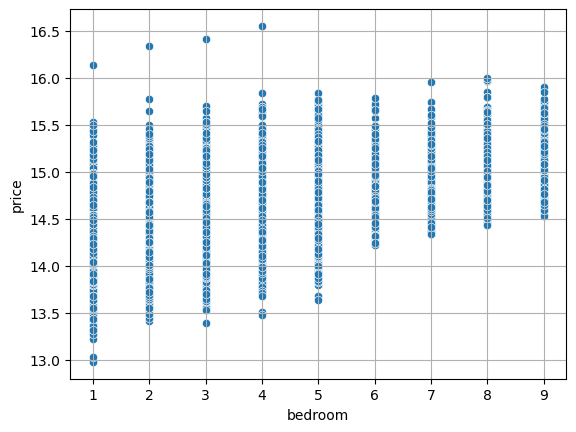

In [32]:
sns.scatterplot(x=train_data['bedroom'], y= np.log(train_data['price']))
plt.grid()

<AxesSubplot:xlabel='bathroom', ylabel='price'>

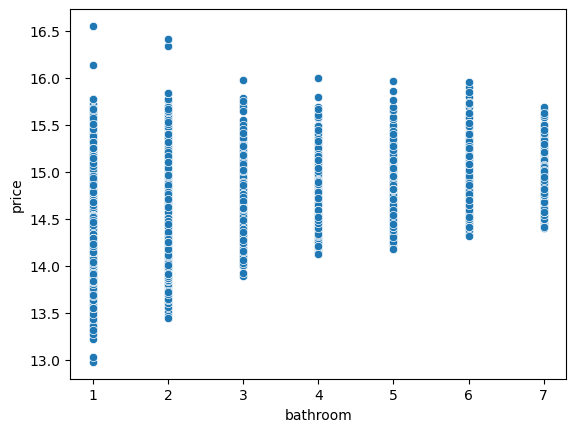

In [33]:
sns.scatterplot(x=train_data['bathroom'], y= np.log(train_data['price']))

In [34]:
train_data[train_data.price < np.exp(13.1)]

,loc,title,bedroom,bathroom,parking_space,price
4481,Gombe,Cottage,1.0,1.0,1.0,431967.2900
13538,Gombe,Cottage,1.0,1.0,1.0,455591.2271


In [35]:
train_data[(train_data.price < np.exp(13.4)) & (train_data.bathroom == 5)]

,loc,title,bedroom,bathroom,parking_space,price


In [36]:
train_data[(train_data.price < np.exp(13.6)) & (train_data.bedroom == 6)]

,loc,title,bedroom,bathroom,parking_space,price


In [37]:
train_data[(train_data.price < np.exp(14.3)) & (train_data.bedroom == 7)]

,loc,title,bedroom,bathroom,parking_space,price


In [38]:
# train_data.drop(train_data[train_data.price > np.exp(16)].index,axis=0,inplace=True)
train_data.drop(train_data[train_data.price < np.exp(13.1)].index,axis=0,inplace=True)
# train_data.drop(train_data[(train_data.price < np.exp(13.6)) & (train_data.bedroom == 6)].index,axis=0,inplace=True)
# # train_data.drop(train_data[(train_data.price_log < np.exp(14.3)) & (train_data.bedroom == 7)].index,axis=0,inplace=True)
# train_data.drop(train_data[(train_data.price < np.exp(13.4)) & (train_data.bathroom == 5)].index,axis=0,inplace=True)


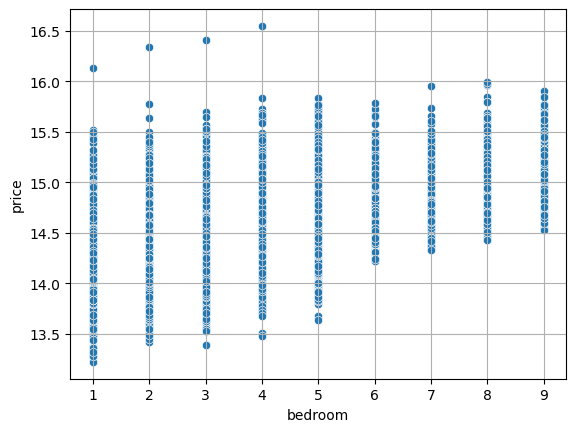

In [39]:
sns.scatterplot(x=train_data['bedroom'], y= np.log(train_data['price']))
plt.grid()

In [40]:
train_data[(train_data.price < np.exp(13.5)) & (train_data.bedroom == 3)]

,loc,title,bedroom,bathroom,parking_space,price
2781,Kebbi,Cottage,3.0,1.0,3.0,651472.544


In [41]:
train_data[(train_data.price < np.exp(13.6)) & (train_data.bedroom == 4)]

,loc,title,bedroom,bathroom,parking_space,price
5037,Gombe,Cottage,4.0,2.0,1.0,737507.5385
13241,Gombe,Cottage,4.0,1.0,1.0,711964.1756


In [42]:
train_data[(train_data.price < np.exp(13.7)) & (train_data.bedroom == 5)]

,loc,title,bedroom,bathroom,parking_space,price
2854,Gombe,Cottage,5.0,1.0,4.0,868973.5528
6161,Kebbi,Cottage,5.0,1.0,1.0,836965.6522


In [43]:
train_data.drop(train_data[(train_data.price < np.exp(13.5)) & (train_data.bedroom == 3)].index,axis=0,inplace=True)
train_data.drop(train_data[(train_data.price < np.exp(13.6)) & (train_data.bedroom == 4)].index,axis=0,inplace=True)
train_data.drop(train_data[(train_data.price < np.exp(13.7)) & (train_data.bedroom == 5)].index,axis=0,inplace=True)

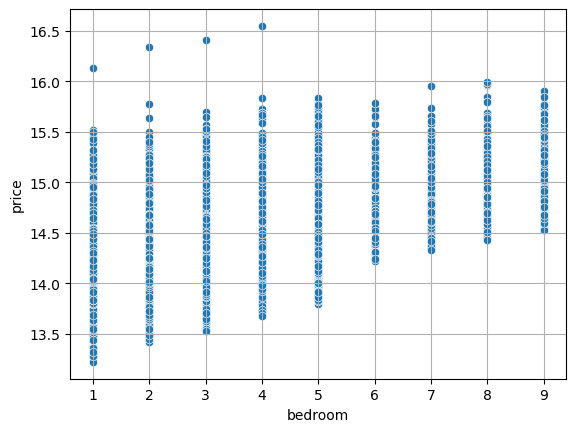

In [44]:
sns.scatterplot(x=train_data['bedroom'], y= np.log(train_data['price']))
plt.grid()

<AxesSubplot:xlabel='bathroom', ylabel='price'>

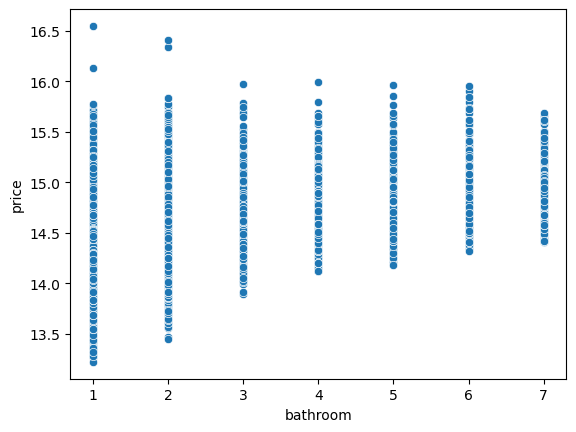

In [45]:
sns.scatterplot(x=train_data['bathroom'], y= np.log(train_data['price']))

In [46]:
test_data[test_data.duplicated()]['title'].nunique()

10

In [47]:
# Selfcon = train_data[(train_data.bedroom == 1 ) & (train_data.bathroom == 1 ) & (train_data.title == 'Apartment')]
# train_data.loc[Selfcon.index,'title'] = 'Selfcon'

# Selfcon = test_data[(test_data.bedroom == 1 ) & (test_data.bathroom == 1 )& (test_data.title == 'Apartment')]
# test_data.loc[Selfcon.index,'title'] = 'Selfcon'

## Helper Functions

In [48]:
# min_price = train_data.groupby(['loc','title']).min().sort_values(by='price',ascending=False)['price'].unstack()

statelist = train_data.groupby('loc').median().sort_values(by='price',ascending=True).index
title_list = train_data.groupby('title').median().sort_values(by='price',ascending=True).index


def ordinalEncoding_loc(X):
    nums = np.array(range(1,len(statelist)+1))
    chocieList =  (nums-nums.mean())/nums.std()
    result = np.select([X == state for state in statelist],nums)
    # result =  (result - result.mean()) / result.std()
    return result

def ordinalEncoding_title(X):

    nums = np.array(range(1,len(title_list)+1))
    chocieList =  (nums-nums.mean())/nums.std()
    result = np.select([X == title for title in title_list],nums)
    # result =  (result - result.mean()) / result.std()
    return result

In [49]:
groupings = train_data.groupby(['loc','title']).mean().sort_values(by='price',ascending=False)['price'].unstack()
title_rank = train_data.groupby('title').mean().sort_values(by='price',ascending=True).index
title_rank = list(title_rank)
title_loc_ordering = {}

for title in groupings.columns:
    rank = title_rank.index(title) + 1
    shift = 36 * (rank - 1)
    title_loc_ordering[title] =  list(groupings[title].sort_values(ascending=True).index)
    title_loc_ordering[title].append(rank)
    title_loc_ordering[title].append(shift)
    
def get_rank(x):
    title,location = x.split('&')
    index = title_loc_ordering[title].index(location) + 1
    deviation = title_loc_ordering[title][-1]
    weight = title_loc_ordering[title][-2]
    return index + weight + deviation


def create_rank(X):
    df  = X.copy()
    features_comb = df['title'] + '&' + df['loc']
    df['rank'] = features_comb.apply(lambda x : get_rank(x))
    mean = df.groupby(['loc'])['rank'].transform('mean')
    # std = df.groupby(['loc'])['rank'].transform('std')
    min_ = df.groupby(['loc'])['rank'].transform('min')
    max_ = df.groupby(['loc'])['rank'].transform('max')
    return (df['rank'] - mean) /(max_- min_)



In [50]:
# train_data.groupby(['title','loc'])['terrain_bed_bath_comb']

In [51]:
train_data[train_data.bedroom < train_data.bathroom].sort_values(by="bathroom",ascending=False)

,loc,title,bedroom,bathroom,parking_space,price


In [52]:
def create_features(data):
    df = data.copy()
    
  
    df['loc_ordinal'] = ordinalEncoding_loc(df['loc'])
    df['title_ordinal'] = ordinalEncoding_title(df['title'])
    
    for title in groupings.columns:
        rank = title_rank.index(title) + 1
        shift = 36 * (rank - 1)
        title_loc_ordering[title] =  list(groupings[title].sort_values(ascending=True).index)
        title_loc_ordering[title].append(rank)
        title_loc_ordering[title].append(shift)
    
    df['rank'] = create_rank(df[['title','loc']])
    df['terrain_2'] = df['loc_ordinal']  * df['rank'] * df['title_ordinal']
    df['terrain'] = df['loc_ordinal']  *  df['title_ordinal']
    
    df['bed_bath_comb'] = (df['bedroom']) + (df['bathroom'] * 0.5 )
    df['bed_bath_ratio'] = (df['bedroom'] / df['bathroom'])
   
     # df['title_ordinal_1'] = df['rank'] * df['title_ordinal']
    # df['title_ordinal_2'] = df['rank'] / df['title_ordinal']
    
    df['terrain_bed'] = df['terrain'] * df['bedroom'] 
    df['terrain_bed_bath_comb'] = df['terrain'] * df['bed_bath_comb'] 
    
  
    df = df.drop([
                    
                      'bed_bath_ratio',
                       'rank',
                     # 'title_ordinal',
                     'bed_bath_comb',
                     # 'terrain',
                    'terrain_bed_bath_comb',
                
    ],axis=1)
    
    
    return df

In [53]:
(train_data['bedroom'] - train_data['bathroom']).mean()

1.924707194645845

In [54]:
def drop_loc_title(df):
    return df.drop(['loc','title'],axis=1)

In [55]:
features_train_data = create_features(train_data)

In [56]:
features_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7172 entries, 0 to 13997
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   loc            7172 non-null   object 
 1   title          7172 non-null   object 
 2   bedroom        7172 non-null   float64
 3   bathroom       7172 non-null   float64
 4   parking_space  7172 non-null   float64
 5   price          7172 non-null   float64
 6   loc_ordinal    7172 non-null   int32  
 7   title_ordinal  7172 non-null   int32  
 8   terrain_2      7172 non-null   float64
 9   terrain        7172 non-null   int32  
 10  terrain_bed    7172 non-null   float64
dtypes: float64(6), int32(3), object(2)
memory usage: 588.3+ KB


In [57]:
features_train_data.describe()

,bedroom,bathroom,parking_space,price,loc_ordinal,title_ordinal,terrain_2,terrain,terrain_bed
count,7172.000000,7172.000000,7172.000000,7.172000e+03,7172.000000,7172.000000,7172.000000,7172.000000,7172.000000
mean,4.272030,2.347323,3.126882,2.129084e+06,18.525934,5.808003,14.894009,108.027328,465.310374
std,2.426618,1.645293,1.471362,1.059496e+06,10.346501,2.699691,40.459841,83.713654,489.405570
min,1.000000,1.000000,1.000000,5.520169e+05,1.000000,1.000000,-37.846154,1.000000,2.000000
25%,2.000000,1.000000,2.000000,1.396287e+06,10.000000,4.000000,-12.091775,40.000000,120.000000
50%,4.000000,2.000000,3.000000,1.886849e+06,18.000000,6.000000,0.917333,87.000000,288.000000
75%,6.000000,3.000000,4.000000,2.575349e+06,27.000000,8.000000,26.765755,160.000000,648.000000
max,9.000000,7.000000,6.000000,1.540273e+07,36.000000,10.000000,160.925104,360.000000,3150.000000


In [58]:
features_train_data.var().sort_values(ascending=False)

C:\Users\EMEKA ONWUEPE\AppData\Local\Temp\ipykernel_12564\3849367518.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  features_train_data.var().sort_values(ascending=False)


price            1.122532e+12
terrain_bed      2.395178e+05
terrain          7.007976e+03
terrain_2        1.636999e+03
loc_ordinal      1.070501e+02
title_ordinal    7.288331e+00
bedroom          5.888477e+00
bathroom         2.706989e+00
parking_space    2.164905e+00
dtype: float64

In [59]:
# encoder = OrdinalEncoder()
# news = encoder.fit_transform(features_train_data)
# news

In [60]:
# features_train_data['loc_1'] = news[:,[0]]
# features_train_data['title_1'] = news[:,[1]]

In [61]:
# features_train_data['rank'].nunique()

<AxesSubplot:>

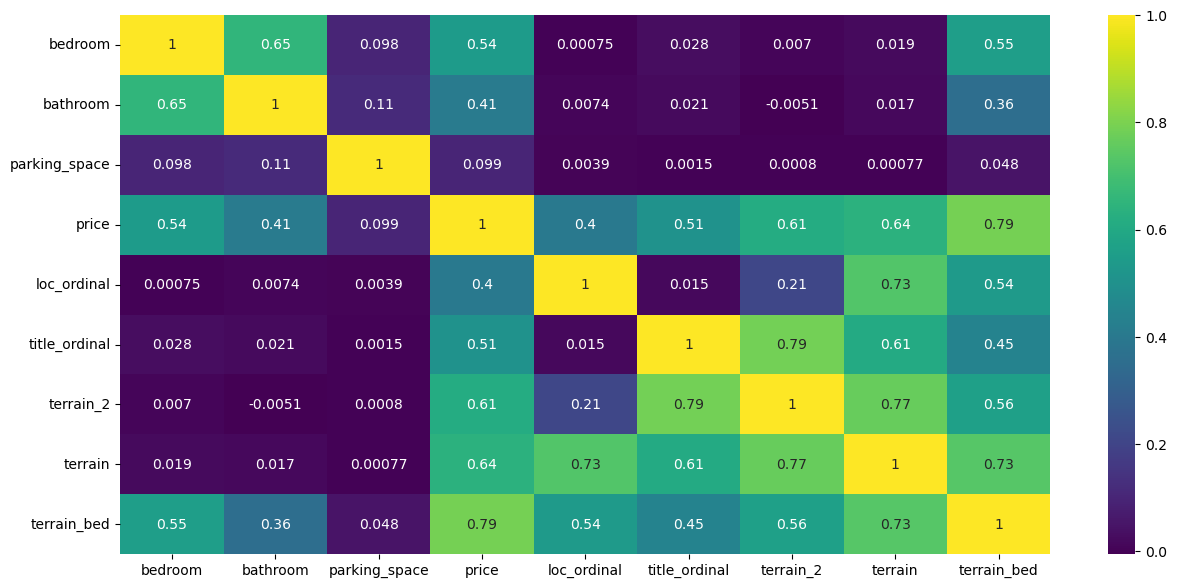

In [62]:
plt.figure(figsize=(15,7))
sns.heatmap(features_train_data.corr(),annot=True,cmap='viridis')

In [63]:
# sns.scatterplot(x=features_train_data['terrain_bed_bath_comb'], y= features_train_data['price'])

In [64]:
features_train_data

,loc,title,bedroom,bathroom,parking_space,price,loc_ordinal,title_ordinal,terrain_2,terrain,terrain_bed
0,Katsina,Semi-detached duplex,2.0,2.0,1.0,1149999.565,20,5,-11.455828,100,200.0
3,Anambra,Detached duplex,5.0,2.0,4.0,2410306.756,25,8,38.479116,200,1000.0
7,Katsina,Penthouse,3.0,3.0,5.0,2043107.592,20,9,60.106782,180,540.0
10,Ogun,Bungalow,1.0,1.0,6.0,1330213.036,32,3,-30.272857,96,96.0
11,Bayelsa,Apartment,3.0,2.0,2.0,1891772.069,35,2,-29.850907,70,210.0
...,...,...,...,...,...,...,...,...,...,...,...
13989,Kebbi,Terrace duplex,4.0,3.0,2.0,1581061.171,3,6,0.685793,18,72.0
13990,Kebbi,Penthouse,8.0,7.0,3.0,3086400.032,3,9,9.416263,27,216.0
13992,Ogun,Cottage,1.0,1.0,2.0,1508351.845,32,1,-17.043333,32,32.0
13994,Taraba,Detached duplex,8.0,1.0,6.0,2837199.086,11,8,23.298668,88,704.0


# KMeans Clusttering

In [65]:
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=239, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        # prediction = self.kmeans_.predict(X)
        # return prediction.reshape(-1,1)
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

# pipeline

In [66]:
num_pipeline = make_pipeline(
    FunctionTransformer(create_features),
    FunctionTransformer(drop_loc_title),
    
    MinMaxScaler(),  
     # PCA(8)
)

cat_pipeline = make_pipeline(
    OneHotEncoder(handle_unknown="ignore"),
    )


cluster_pipeline = make_pipeline(
    ColumnTransformer([
   
    ("one_hot", cat_pipeline, ['loc','title']),
    ],remainder= 'passthrough'),
   
    ClusterSimilarity(n_clusters=36, gamma= 1., random_state=42),
     
)
# 378

In [67]:
preprocessing = make_pipeline( ColumnTransformer([

    ("num", num_pipeline,make_column_selector(dtype_exclude=None)),
    ("cat", cat_pipeline,  make_column_selector(dtype_include=object) ),   
    ("geo", cluster_pipeline, ['loc',"title",'bedroom','bathroom']),
]),

 
                             )

In [68]:
model = TransformedTargetRegressor(svm.SVR(gamma=0.2),
                                  transformer = StandardScaler() )

# model = XGBRegressor(gamma=0.2)

reg_model = Pipeline([('preprocessing', preprocessing) ,('model', model)] )

reg_model

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('functiontransformer-1',
                                                                                    FunctionTransformer(func=<function create_features at 0x00000171B9544670>)),
                                                                                   ('functiontransformer-2',
                                                                                    FunctionTransformer(func=<function drop_loc_title at 0x00000171B9544DC0>)),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler()...
                                                                                    ColumnTransformer(remainder='passthrough',
                                                                                                      transformers=[('one_hot',
                                                                                                                     Pipeline(steps=[('onehotencoder',
                                                                                                                                      OneHotEncoder(handle_unknown='ignore'))]),
                                                                                                                     ['loc',
                                                                                                                      'title'])])),
                                                                                   ('clustersimilarity',
                                                                                    ClusterSimilarity(n_clusters=36,
                                                                                                      random_state=42))]),
                                                                   ['loc',
                                                                    'title',
                                                                    'bedroom',
                                                                    'bathroom'])]))])),
                ('model',
                 TransformedTargetRegressor(regressor=SVR(gamma=0.2),
                                            transformer=StandardScaler()))])

In [69]:
preprocessing.fit_transform(train_data.drop('price',axis=1)).shape

(7172, 90)

In [70]:
train_data.drop('price',axis=1).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7172 entries, 0 to 13997
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   loc            7172 non-null   object 
 1   title          7172 non-null   object 
 2   bedroom        7172 non-null   float64
 3   bathroom       7172 non-null   float64
 4   parking_space  7172 non-null   float64
dtypes: float64(3), object(2)
memory usage: 336.2+ KB


In [71]:
strat_train_set, strat_test_set = train_test_split(
    train_data, test_size=0.3, stratify=train_data["title"], random_state=42)

train_features = strat_train_set.drop('price',axis=1)
train_label = strat_train_set.price

test_features = strat_test_set.drop('price',axis=1)
test_label = strat_test_set.price

In [72]:
reg_model.fit(train_features, train_label)
housing_predictions = reg_model.predict(test_features)
model_rmse = mean_squared_error(test_label, housing_predictions,
                                 squared=False)
model_rmse

# 352223.64484963444
# 350660.16205413145
# 349164.45534796186
# 351357.6927873449

290482.197906317

In [73]:
# help(XGBRegressor())

In [74]:
# parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
#               'C': np.logspace(-3, 3, 5),
#               'gamma':np.logspace(-3, 3, 5)}
# svm = SVC()


# # svm_cv = GridSearchCV(svm,parameters,cv=10)
# # svm_cv.fit(X_train,Y_train)

# from sklearn.model_selection import GridSearchCV

# # # full_pipeline = Pipeline([
# # #     ("preprocessing", preprocessing),
# # #     ("random_forest", RandomForestRegressor(random_state=42)),
# # # ])

# param_grid = [
#     {
#     # 'model__regressor__kernel': ('linear', 'rbf','poly', 'sigmoid'),
#      # 'model__regressor__C':  np.logspace(-3, 3, 5),
#      # 'model__regressor__gamma': np.logspace(-3, 3, 5),
#      # 'model__regressor__epsilon': [1,2,3,4,5],
#       'preprocessing__geo__clustersimilarity__n_clusters': list(range(90,100))
#      }
# ]

# param_grid = [
#     {
        # 'preprocessing__geo__clustersimilarity__n_clusters': list(range(90,100)),
        # 'model__regressor__kernel': ('linear', 'rbf','poly','rbf', 'sigmoid'),
        #  'model__regressor__C':  np.logspace(-3, 3, 5),
#         'model__regressor__gamma': np.array(list(range(1,11))) /10,
#     }
# ]
# grid_search = GridSearchCV(reg_model, param_grid, cv=3,
#                           scoring='neg_root_mean_squared_error')
# grid_search.fit(train_data.drop('price',axis=1), train_data.price)

In [75]:
reg_model.fit(train_data.drop('price',axis=1), train_data.price)
housing_forcast = reg_model.predict(test_data)
# housing_forcast = np.expm1(housing_forcast)
print(housing_forcast)

# ids = test_data.reset_index()['ID']

print(test_ids)

data = {'ID':test_ids,'price':housing_forcast}

submission = pd.DataFrame(data)
# submission.price = submission.price.apply(lambda x:round(x))
submission.set_index('ID',inplace=True)
submission.to_csv('forcast.csv')

# [2339564.59542481  985677.61331304 1189522.735418   ... 1985574.42349451
#  1300250.0620549  3351963.28773246]

# 2337458.71318264
# 2351380.8939843
# 2348510.83518717
# 2341164.29202909

# 2330401.87713812

[2327845.04970991  972755.93535073 1073167.70487795 ... 1958320.75911221
 1251580.53801163 3220078.82587994]
0         845
1        1924
2       10718
3       12076
4       12254
        ...  
5995     1594
5996     2416
5997    10195
5998     9455
5999    11736
Name: ID, Length: 6000, dtype: int64


In [76]:
# 339459.7513

In [77]:
housing_predictions = reg_model.predict(train_data.drop('price',axis=1))
model_rmse = mean_squared_error(train_data.price, housing_predictions,
                                 squared=False)
model_rmse

# 315345.984775595
# 315508.5965551834
# 315450.3744717779
# 314987.2555388389

# 333729.9691617605

# 333973.79314003675

336147.83974083705

In [78]:
# from sklearn.model_selection import GridSearchCV

# param_grid = [
#     {
#         'model__regressor__gamma': np.array(list(range(1,11))) /10,
#         # 'preprocessing__geo__clustersimilarity__gamma': np.array(list(range(1,11))) /10,
#         # 'model__regressor__kernel': ('linear', 'rbf','poly', 'sigmoid'),
#       # 'model__regressor__C':  np.array(list(range(1,11))) /10,
#     }
# ]
# grid_search = GridSearchCV(reg_model, param_grid, cv=3,
#                           scoring='neg_root_mean_squared_error')
# grid_search.fit(train_data.drop('price',axis=1), train_data.price)

In [79]:
# grid_search.best_params_

In [80]:
# reg_gamma 0.1,0.2
# clus gamma 0.1

In [81]:
# train_data.loc[abnormal_bathrooms,'bathroom'].shape 